<a href="https://colab.research.google.com/github/DeemonDuck/codealpha_tasks/blob/main/Emotion_Recognition_From_Speech_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting up the Kaggle API key
import os

!mkdir -p ~/.kaggle

!cp "/content/drive/MyDrive/CODEALPHA_PROJECTS/SPEECH_EMOTION_RECOGNITION/kaggle.json" ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle key is set up.")

Kaggle key is set up.


In [ ]:
!cp "/content/drive/MyDrive/CODEALPHA_PROJECTS/SPEECH_EMOTION_RECOGNITION/ravdess-emotional-speech-audio.zip" .

!unzip -q ravdess-emotional-speech-audio.zip -d ./ravdess_data

print("Dataset copied from Drive and unzipped into 'ravdess_data' folder!")

Dataset copied from Drive and unzipped into 'ravdess_data' folder!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


DATA_PATH = "./ravdess_data/"

TARGET_SR = 22050

N_MELS = 128

MAX_PAD_LEN = 250

In [ ]:
file_paths = []
emotions = []
actors = []

# Map emotion codes to names (from RAVDESS documentation)
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

print("Parsing filenames...")
for dir in os.listdir(DATA_PATH):
    if dir.startswith("Actor_"):
        actor_dir_path = os.path.join(DATA_PATH, dir)
        for file in os.listdir(actor_dir_path):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_dir_path, file)
                parts = file.split('.')[0].split('-')
                emotion_code = parts[2]
                actor_id = int(parts[6])
                if emotion_code in emotion_map:
                    file_paths.append(file_path)
                    emotions.append(emotion_map[emotion_code])
                    actors.append(actor_id)

print(f"Parsed {len(file_paths)} audio files.")

df = pd.DataFrame({
    'path': file_paths,
    'emotion': emotions,
    'actor': actors
})


print("\nDataFrame created:")
print(df.head())
print("\nEmotion distribution:")
print(df['emotion'].value_counts())

Parsing filenames...
Parsed 1440 audio files.

DataFrame created:
                                               path    emotion  actor
0  ./ravdess_data/Actor_17/03-01-08-01-02-01-17.wav  surprised     17
1  ./ravdess_data/Actor_17/03-01-04-02-01-01-17.wav        sad     17
2  ./ravdess_data/Actor_17/03-01-08-02-01-02-17.wav  surprised     17
3  ./ravdess_data/Actor_17/03-01-08-02-02-02-17.wav  surprised     17
4  ./ravdess_data/Actor_17/03-01-05-02-01-02-17.wav      angry     17

Emotion distribution:
emotion
surprised    192
sad          192
angry        192
happy        192
disgust      192
fearful      192
calm         192
neutral       96
Name: count, dtype: int64


In [ ]:
def get_features(path):
    try:
        y, sr = librosa.load(path, sr=TARGET_SR)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
        S_db = librosa.power_to_db(S, ref=np.max)
        if S_db.shape[1] > MAX_PAD_LEN:
            S_db = S_db[:, :MAX_PAD_LEN]
        else:
            pad_width = MAX_PAD_LEN - S_db.shape[1]
            S_db = np.pad(S_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None
    return S_db

print("\nExtracting Mel Spectrogram features...")
X = []
for path in tqdm(df['path']):
    features = get_features(path)
    if features is not None:
        X.append(features)

X = np.array(X)
print(f"\nFeature extraction complete. Shape of X: {X.shape}")

le = LabelEncoder()
y = le.fit_transform(df['emotion'])
print(f"\nLabels created. Shape of y: {y.shape}")
print(f"Emotion labels mapping: {list(zip(le.classes_, range(len(le.classes_))))}")

X = X.reshape(X.shape[0], N_MELS, MAX_PAD_LEN, 1)
print(f"Reshaped X for CNN input: {X.shape}")


Extracting Mel Spectrogram features...


  0%|          | 0/1440 [00:00<?, ?it/s]


Feature extraction complete. Shape of X: (1440, 128, 250)

Labels created. Shape of y: (1440,)
Emotion labels mapping: [('angry', 0), ('calm', 1), ('disgust', 2), ('fearful', 3), ('happy', 4), ('neutral', 5), ('sad', 6), ('surprised', 7)]
Reshaped X for CNN input: (1440, 128, 250, 1)


In [ ]:
## Creating Speaker-Independent Data Split

from sklearn.model_selection import train_test_split
import numpy as np

actors = df['actor'].values

test_actors = [21, 22, 23, 24]

# Creating boolean masks for splitting
train_mask = ~np.isin(actors, test_actors) # Use '~' for NOT IN
test_mask = np.isin(actors, test_actors)

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

actors_train = actors[train_mask]
actors_test = actors[test_mask]

# Converting labels to categorical (one-hot encoding)
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)


print("--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

print(f"\nUnique actors in training set: {np.unique(actors_train)}")
print(f"Unique actors in testing set: {np.unique(actors_test)}")
print(f"\nNumber of classes: {num_classes}")

--- Data Shapes ---
X_train shape: (1200, 128, 250, 1)
y_train_cat shape: (1200, 8)
X_test shape: (240, 128, 250, 1)
y_test_cat shape: (240, 8)

Unique actors in training set: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Unique actors in testing set: [21 22 23 24]

Number of classes: 8


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)
input_shape = (N_MELS, MAX_PAD_LEN, 3)
print(f"Shape after repeating channels: {X_train_rgb.shape}")

# Loading the base model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

base_model.trainable = False
print(f"Base model loaded. Trainable: {base_model.trainable}")

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel built successfully:")
model.summary()

Shape after repeating channels: (1200, 128, 250, 3)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Base model loaded. Trainable: False

Model built successfully:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 332,552 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# Training the Model with Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_emotion_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

epochs = 50
batch_size = 32

print("\nStarting model training...")
history = model.fit(
    X_train_rgb, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_rgb, y_test_cat),
    callbacks=[early_stopping, model_checkpoint]
)

print("\nTraining complete.")


Starting model training...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 781ms/step - accuracy: 0.2334 - loss: 2.4691 - val_accuracy: 0.2333 - val_loss: 1.9558
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3412 - loss: 2.1577 - val_accuracy: 0.3667 - val_loss: 1.9047
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3831 - loss: 1.8409 - val_accuracy: 0.3458 - val_loss: 1.8692
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4007 - loss: 1.8092 - val_accuracy: 0.3792 - val_loss: 1.8328
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4098 - loss: 1.7289 - val_accuracy: 0.3958 - val_loss: 1.7680
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4154 - loss: 1.6426 - val_accuracy: 0.4000 - val_loss: 1.7396
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4276 - loss: 1.5754 - val_accuracy: 0.4167 - val_loss: 1.7353
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4495 - loss: 1.5

In [ ]:
# Evaluating the Model on the Test Set

print("Evaluating the model on the test set...")
loss, accuracy = model.evaluate(X_test_rgb, y_test_cat, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Evaluating the model on the test set...

Test Loss: 1.7257
Test Accuracy: 47.50%



Plotting training history...


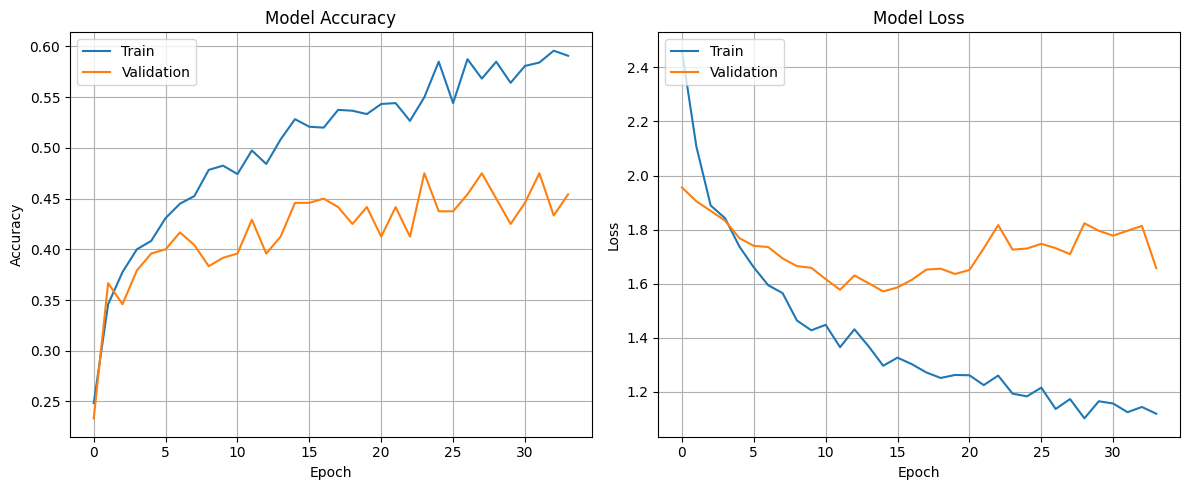

In [ ]:
import matplotlib.pyplot as plt

print("\nPlotting training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Trying to improve accuracy by
1. Unfreezing the Base Layers in NetEfficientBO Model
2. Lowering the Learning Rate

In [ ]:
# Preparing for Fine-Tuning

print("Loading weights from best model...")
model.load_weights('best_emotion_model.keras')

# --- Unfreeze the base model ---
print("Unfreezing base model layers...")
base_model.trainable = True

print(f"Number of layers in the base model: {len(base_model.layers)}")
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_lr = 0.00001 # 1e-5
optimizer = Adam(learning_rate=fine_tune_lr)

print(f"Re-compiling model with learning rate: {fine_tune_lr}")
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Printing model summary again (shows more trainable params now)
model.summary()

Loading weights from best model...
Unfreezing base model layers...
Number of layers in the base model: 238
Re-compiling model with learning rate: 1e-05


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 4,172,900 (15.92 MB)

 Non-trainable params: 211,783 (827.28 KB)

In [ ]:
fine_tune_epochs = 20

initial_epoch = len(history.history['loss'])

print(f"\nStarting fine-tuning from epoch {initial_epoch}...")

# Continue training
history_fine = model.fit(
    X_train_rgb, y_train_cat,
    epochs=initial_epoch + fine_tune_epochs,
    initial_epoch=initial_epoch,
    batch_size=batch_size,                  # Can potentially reduce batch size if memory becomes an issue which is in Google Collab
    validation_data=(X_test_rgb, y_test_cat),
    callbacks=[early_stopping, model_checkpoint] # Same callbacks (saving best weights)
)

print("\nFine-tuning complete.")

# Loading the absolute best weights again
print("Loading best weights achieved during fine-tuning...")
model.load_weights('best_emotion_model.keras')


Starting fine-tuning from epoch 34...
Epoch 35/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.1124 - loss: 2.8323 - val_accuracy: 0.2958 - val_loss: 2.1870
Epoch 36/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.1695 - loss: 2.5841 - val_accuracy: 0.2625 - val_loss: 2.3130
Epoch 37/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2167 - loss: 2.3028 - val_accuracy: 0.1958 - val_loss: 2.4151
Epoch 38/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2003 - loss: 2.2549 - val_accuracy: 0.1917 - val_loss: 2.3332
Epoch 39/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2690 - loss: 2.0401 - val_accuracy: 0.2083 - val_loss: 2.1528
Epoch 40/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3139 - loss: 1.9604 - val_accuracy: 0.2333 - val_loss: 2.0284
Epoch 41/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3373 - loss: 1.7885 - val_accuracy: 0.2333 - val_loss: 1.9576
Epoch 42/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.

In [ ]:
# Evaluating the Model on the Test Set

print("Evaluating the final model on the test set...")
loss, accuracy = model.evaluate(X_test_rgb, y_test_cat, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Evaluating the final model on the test set...

Test Loss: 1.7257
Test Accuracy: 47.50%


In [ ]:
# Copying the Best Model File to Google Drive

drive_save_path = "/content/drive/MyDrive/CODEALPHA_PROJECTS/SPEECH_EMOTION_RECOGNITION/" # Make sure this path is correct

!cp best_emotion_model.keras "{drive_save_path}"

print(f"Latest best model saved to Google Drive at: {drive_save_path}")

Latest best model saved to Google Drive at: /content/drive/MyDrive/CODEALPHA_PROJECTS/SPEECH_EMOTION_RECOGNITION/
